# QVM ENGINE V3J TEARSHEET DEMONSTRATION

This notebook demonstrates the QVM (Quality, Value, Momentum) factor investing strategy with comprehensive performance analysis and visualization.

# IMPORTS AND SETUP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, date
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
import sys
sys.path.append('/home/raymond/Documents/Projects/factor-investing-public')
from production.database.connection import DatabaseManager

# REGIME DETECTION COMPONENT

In [3]:
class RegimeDetector:
    """
    Advanced regime detection based on volatility and return thresholds with stability controls.
    """
    def __init__(self, lookback_period: int = 90, volatility_threshold: float = 0.75, 
                 return_threshold: float = 0.25, bull_return_threshold: float = 0.75,
                 min_regime_duration: int = 5):
        self.lookback_period = lookback_period
        self.volatility_threshold = volatility_threshold
        self.return_threshold = return_threshold
        self.bull_return_threshold = bull_return_threshold
        self.min_regime_duration = min_regime_duration
        print(f"✅ RegimeDetector initialized with thresholds:")
        print(f"   - Lookback Period: {self.lookback_period} days")
        print(f"   - Volatility Threshold: {self.volatility_threshold:.2%} (percentile)")
        print(f"   - Return Threshold: {self.return_threshold:.2%} (percentile)")
        print(f"   - Bull Return Threshold: {self.bull_return_threshold:.2%} (percentile)")
        print(f"   - Min Regime Duration: {self.min_regime_duration} days")
    
    def detect_regime(self, benchmark_data: pd.DataFrame) -> pd.DataFrame:
        """Detect market regime based on benchmark performance with stability controls."""
        print("📊 Detecting market regime with stability controls...")
        
        # Calculate rolling volatility and returns
        benchmark_data = benchmark_data.sort_values('date').copy()
        benchmark_data['rolling_vol'] = benchmark_data['return'].rolling(self.lookback_period).std() * np.sqrt(252)
        benchmark_data['rolling_return'] = benchmark_data['return'].rolling(self.lookback_period).mean() * 252
        
        # Define regime thresholds based on percentiles
        vol_threshold = benchmark_data['rolling_vol'].quantile(self.volatility_threshold)
        return_threshold = benchmark_data['rolling_return'].quantile(self.return_threshold)
        bull_return_threshold = benchmark_data['rolling_return'].quantile(self.bull_return_threshold)
        
        # Initial regime classification
        benchmark_data['regime'] = 'normal'
        benchmark_data.loc[
            (benchmark_data['rolling_vol'] > vol_threshold) & 
            (benchmark_data['rolling_return'] < return_threshold), 'regime'
        ] = 'stress'
        benchmark_data.loc[
            (benchmark_data['rolling_vol'] < vol_threshold) & 
            (benchmark_data['rolling_return'] > bull_return_threshold), 'regime'
        ] = 'bull'
        
        # Apply minimum regime duration filter to reduce volatility and make periods more contiguous
        print(f"   📊 Applying minimum regime duration filter ({self.min_regime_duration} days)...")
        
        # Forward fill regimes to ensure minimum duration
        benchmark_data['regime_stable'] = benchmark_data['regime']
        
        # Use rolling window to smooth regime changes and make periods more contiguous
        for i in range(self.min_regime_duration, len(benchmark_data)):
            # Check if we have enough consecutive days in the same regime
            recent_regimes = benchmark_data['regime'].iloc[i-self.min_regime_duration+1:i+1]
            if len(recent_regimes.unique()) == 1:
                # Stable regime, keep it
                benchmark_data.iloc[i, benchmark_data.columns.get_loc('regime_stable')] = recent_regimes.iloc[0]
            else:
                # Unstable, keep previous stable regime
                if i > 0:
                    benchmark_data.iloc[i, benchmark_data.columns.get_loc('regime_stable')] = benchmark_data.iloc[i-1]['regime_stable']
        
        # Additional smoothing: eliminate isolated regime changes using forward/backward fill
        print(f"   📊 Applying additional smoothing to eliminate isolated regime changes...")
        
        # Create a copy for smoothing
        benchmark_data['regime_smooth'] = benchmark_data['regime_stable'].copy()
        
        # Find isolated regime changes (regimes that only last 1-2 days)
        for i in range(1, len(benchmark_data) - 1):
            current_regime = benchmark_data.iloc[i]['regime_stable']
            prev_regime = benchmark_data.iloc[i-1]['regime_stable']
            next_regime = benchmark_data.iloc[i+1]['regime_stable']
            
            # If current regime is isolated (different from both previous and next)
            if current_regime != prev_regime and current_regime != next_regime:
                # Check if it's a very short regime (1-2 days)
                # Look forward and backward to see how long this regime lasts
                forward_count = 0
                backward_count = 0
                
                # Count forward
                for j in range(i+1, len(benchmark_data)):
                    if benchmark_data.iloc[j]['regime_stable'] == current_regime:
                        forward_count += 1
                    else:
                        break
                
                # Count backward
                for j in range(i-1, -1, -1):
                    if benchmark_data.iloc[j]['regime_stable'] == current_regime:
                        backward_count += 1
                    else:
                        break
                
                # If total regime duration is very short (<= 3 days), smooth it
                total_duration = forward_count + backward_count + 1
                if total_duration <= 3:
                    # Use the regime that appears more frequently in the surrounding window
                    window_start = max(0, i-5)
                    window_end = min(len(benchmark_data), i+6)
                    window_regimes = benchmark_data.iloc[window_start:window_end]['regime_stable']
                    
                    # Count regimes in the window
                    regime_counts = window_regimes.value_counts()
                    # Remove the current isolated regime from consideration
                    if current_regime in regime_counts:
                        regime_counts = regime_counts.drop(current_regime)
                    
                    if not regime_counts.empty:
                        # Use the most common regime in the window
                        most_common_regime = regime_counts.index[0]
                        benchmark_data.iloc[i, benchmark_data.columns.get_loc('regime_smooth')] = most_common_regime
        
        # Use smoothed regime as final regime
        benchmark_data['regime'] = benchmark_data['regime_smooth']
        benchmark_data = benchmark_data.drop(['regime_stable', 'regime_smooth'], axis=1)
        
        print(f"   ✅ Regime detection completed with stability controls")
        print(f"   📊 Regime distribution:")
        regime_counts = benchmark_data['regime'].value_counts()
        for regime, count in regime_counts.items():
            print(f"      {regime}: {count} days ({count/len(benchmark_data)*100:.1f}%)")
        
        # Calculate regime stability metrics
        regime_changes = (benchmark_data['regime'] != benchmark_data['regime'].shift()).sum()
        print(f"   📊 Regime stability: {regime_changes} changes over {len(benchmark_data)} days")
        
        return benchmark_data
    
    def get_regime_allocation(self, regime: str) -> float:
        """Get target allocation based on regime."""
        regime_allocations = {
            'normal': 0.8,    # 80% invested during normal periods
            'bull': 1.0,      # 100% invested during bull periods
            'stress': 0.4,    # 40% invested during stress periods
        }
        return regime_allocations.get(regime, 0.8)

# CONFIGURATION

In [4]:
CONFIG = {
    'strategy_name': 'QVM_Engine_v3j_Tearsheet_Demo_v19',
    'universe': {
        'lookback_days': 252,
        'top_n_stocks': 20,
        'target_portfolio_size': 20,
        'adtv_threshold_bn': 10,  # 10 billion VND ADTV
    },
    'backtest_start_date': '2016-01-01',
    'backtest_end_date': '2025-12-31',
    'rebalance_frequency': 'M',  # Monthly
    'transaction_cost_bps': 10,  # 10 basis points
    'initial_capital': 10_000_000_000,  # 10 billion VND
    'regime_detection': {
        'lookback_days': 90,  # 90 days lookback for regime detection
        'volatility_threshold': 0.85,  # 85th percentile for high volatility (more conservative)
        'return_threshold': 0.15,  # 15th percentile for low returns (more conservative)
        'bull_return_threshold': 0.75,  # 75th percentile for high returns
        'min_regime_duration': 30,  # Increased to 30 days for more stable regimes
        'stress_drawdown_threshold': 0.20,  # 20% drawdown threshold for stress classification
    },
    'factor_weights': {
        'normal': {'quality': 0.33, 'value': 0.33, 'momentum': 0.34, 'allocation': 0.8},
        'stress': {'quality': 0.5, 'value': 0.4, 'momentum': 0.1, 'allocation': 0.4},
        'bull': {'quality': 0.15, 'value': 0.25, 'momentum': 0.6, 'allocation': 1.0},
    }
}

# DATABASE CONNECTION

In [5]:
# Initialize database connection
db_manager = DatabaseManager()
engine = db_manager.get_engine()
print("✅ Database connected")

2025-08-08 00:40:17,746 - production.database.connection - INFO - Database configuration loaded from /home/raymond/Documents/Projects/factor-investing-public/config/database.yml
2025-08-08 00:40:17,746 - production.database.connection - INFO - DatabaseManager initialized for environment: production
2025-08-08 00:40:17,761 - production.database.connection - INFO - SQLAlchemy engine created successfully


✅ Database connected


# LOAD HOLDINGS DATA

In [6]:
# Load holdings data from pre-generated file
holdings_file = Path("docs/18b_complete_holdings.csv")
if holdings_file.exists():
    holdings_df = pd.read_csv(holdings_file)
    holdings_df['date'] = pd.to_datetime(holdings_df['date']).dt.date
    print(f"✅ Loaded holdings: {len(holdings_df)} records")
else:
    print("❌ Holdings file not found, using database query...")
    query = """
    SELECT date, ticker, Quality_Composite as quality_score, Value_Composite as value_score, 
           Momentum_Composite as momentum_score, QVM_Composite as composite_score
    FROM factor_scores_qvm 
    WHERE date BETWEEN %s AND %s
    ORDER BY date, QVM_Composite DESC
    """
    holdings_df = pd.read_sql(query, engine, params=(CONFIG['backtest_start_date'], CONFIG['backtest_end_date']))
    holdings_df['date'] = pd.to_datetime(holdings_df['date']).dt.date
    print(f"✅ Loaded holdings: {len(holdings_df)} records")

✅ Loaded holdings: 75539 records


# LOAD PRICE DATA

In [7]:
print("📊 Loading price data...")
unique_tickers = holdings_df['ticker'].unique()
ticker_list = "', '".join(unique_tickers)

price_query = f"""
SELECT 
    trading_date as date,
    ticker,
    close_price
FROM vcsc_daily_data_complete
WHERE ticker IN ('{ticker_list}')
AND trading_date >= '{holdings_df['date'].min()}'
AND trading_date <= '{holdings_df['date'].max()}'
ORDER BY trading_date, ticker
"""

price_data = pd.read_sql(price_query, engine)
price_data['date'] = pd.to_datetime(price_data['date']).dt.date
print(f"✅ Price data: {len(price_data)} records")

📊 Loading price data...
✅ Price data: 1581176 records


# LOAD BENCHMARK DATA

In [8]:
print("📊 Loading benchmark data...")
benchmark_query = f"""
SELECT 
    date,
    close as close_price
FROM etf_history
WHERE ticker = 'VNINDEX'
AND date >= '{holdings_df['date'].min()}'
AND date <= '{holdings_df['date'].max()}'
ORDER BY date
"""

benchmark_data = pd.read_sql(benchmark_query, engine)
benchmark_data['date'] = pd.to_datetime(benchmark_data['date']).dt.date
benchmark_data['return'] = benchmark_data['close_price'].pct_change()
print(f"✅ Benchmark data: {len(benchmark_data)} records")

📊 Loading benchmark data...
✅ Benchmark data: 2369 records


# DETECT MARKET REGIME

In [9]:
# Initialize regime detector
regime_detector = RegimeDetector(
    lookback_period=CONFIG['regime_detection']['lookback_days'],
    volatility_threshold=CONFIG['regime_detection']['volatility_threshold'],
    return_threshold=CONFIG['regime_detection']['return_threshold'],
    bull_return_threshold=CONFIG['regime_detection']['bull_return_threshold'],
    min_regime_duration=CONFIG['regime_detection']['min_regime_duration']
)

# Detect market regime
benchmark_data = regime_detector.detect_regime(benchmark_data)
print(f"✅ Market regime detection completed")

✅ RegimeDetector initialized with thresholds:
   - Lookback Period: 90 days
   - Volatility Threshold: 85.00% (percentile)
   - Return Threshold: 15.00% (percentile)
   - Bull Return Threshold: 75.00% (percentile)
   - Min Regime Duration: 30 days
📊 Detecting market regime with stability controls...
   📊 Applying minimum regime duration filter (30 days)...
   📊 Applying additional smoothing to eliminate isolated regime changes...
   ✅ Regime detection completed with stability controls
   📊 Regime distribution:
      normal: 1666 days (70.3%)
      bull: 416 days (17.6%)
      stress: 287 days (12.1%)
   📊 Regime stability: 15 changes over 2369 days
✅ Market regime detection completed


# CALCULATE PORTFOLIO RETURNS

In [10]:
def calculate_corrected_returns(holdings_df, price_data, benchmark_data, config, regime_detector):
    """Calculate corrected portfolio returns with regime-based allocation."""
    print("📈 Calculating corrected portfolio returns with regime detection...")
    
    # Convert dates to datetime
    holdings_df['date'] = pd.to_datetime(holdings_df['date'])
    price_data['date'] = pd.to_datetime(price_data['date'])
    benchmark_data['date'] = pd.to_datetime(benchmark_data['date'])
    
    # Create price matrix with forward filling
    print("   📊 Creating price matrix with forward filling...")
    price_matrix = price_data.pivot(index='date', columns='ticker', values='close_price')
    
    # Forward fill prices (carry last known price forward)
    price_matrix = price_matrix.fillna(method='ffill')
    
    # Backward fill any remaining NaN values at the beginning
    price_matrix = price_matrix.fillna(method='bfill')
    
    print(f"   ✅ Price matrix created: {price_matrix.shape}")
    
    # Get unique rebalancing dates
    unique_dates = sorted(holdings_df['date'].unique())
    
    portfolio_values = []
    daily_returns = []
    current_capital = config['initial_capital']
    
    for i, date in enumerate(unique_dates):
        # Get holdings for this date
        date_holdings = holdings_df[holdings_df['date'] == date]
        
        if date_holdings.empty:
            continue
        
        # Get current market regime
        regime_info = benchmark_data[benchmark_data['date'] == date]
        if not regime_info.empty:
            current_regime = regime_info['regime'].iloc[0]
            regime_allocation = regime_detector.get_regime_allocation(current_regime)
        else:
            current_regime = 'normal'
            regime_allocation = 0.8
        
        # Get prices for this date from the forward-filled matrix
        if date in price_matrix.index:
            date_prices = price_matrix.loc[date]
        else:
            # Find the closest available date
            available_dates = price_matrix.index[price_matrix.index <= date]
            if not available_dates.empty:
                closest_date = available_dates[-1]
                date_prices = price_matrix.loc[closest_date]
            else:
                continue
        
        # Calculate portfolio value with regime-based allocation
        portfolio_value = 0
        valid_holdings = 0
        
        for _, holding in date_holdings.iterrows():
            ticker = holding['ticker']
            if ticker in date_prices.index:
                price = date_prices[ticker]
                if pd.notna(price) and price > 0:
                    # Apply regime-based allocation
                    position_size = (current_capital * regime_allocation) / len(date_holdings)
                    shares = position_size / price
                    portfolio_value += shares * price
                    valid_holdings += 1
        
        if portfolio_value > 0 and valid_holdings > 0:
            portfolio_values.append({
                'date': date,
                'portfolio_value': portfolio_value,
                'capital': current_capital,
                'valid_holdings': valid_holdings,
                'total_holdings': len(date_holdings),
                'regime': current_regime,
                'regime_allocation': regime_allocation
            })
            
            # Calculate daily returns for the period until next rebalancing
            if i < len(unique_dates) - 1:
                next_date = unique_dates[i + 1]
                
                # Get price data for the period (only trading days)
                period_dates = price_matrix.index[
                    (price_matrix.index >= date) & 
                    (price_matrix.index <= next_date)
                ]
                
                if len(period_dates) > 1:
                    # Calculate daily returns for each stock
                    period_prices = price_matrix.loc[period_dates]
                    
                    # Calculate daily returns (pct_change)
                    period_returns = period_prices.pct_change()
                    
                    # Calculate portfolio daily returns
                    for daily_date in period_returns.index[1:]:  # Skip first date (no return)
                        daily_returns_data = period_returns.loc[daily_date]
                        
                        # Get only the stocks in our portfolio
                        portfolio_tickers = date_holdings['ticker'].unique()
                        portfolio_daily_returns = daily_returns_data[daily_returns_data.index.isin(portfolio_tickers)]
                        
                        if not portfolio_daily_returns.empty:
                            # Filter out extreme returns (likely data errors)
                            portfolio_daily_returns = portfolio_daily_returns[
                                (portfolio_daily_returns >= -0.5) & (portfolio_daily_returns <= 0.5)
                            ]
                            
                            if len(portfolio_daily_returns) > 0:
                                # Equal weight portfolio return
                                portfolio_return = portfolio_daily_returns.mean()
                                
                                # Apply transaction costs on rebalancing day
                                if daily_date == date:
                                    transaction_cost = config['transaction_cost_bps'] / 10000
                                    portfolio_return -= transaction_cost
                                
                                # Only include valid returns (not NaN or extreme)
                                if pd.notna(portfolio_return) and abs(portfolio_return) < 0.5:
                                    daily_returns.append({
                                        'date': daily_date,
                                        'portfolio_return': portfolio_return,
                                        'rebalance_date': date,
                                        'regime': current_regime,
                                        'regime_allocation': regime_allocation
                                    })
            
            # Update capital for next period
            current_capital = portfolio_value
    
    portfolio_df = pd.DataFrame(portfolio_values)
    daily_returns_df = pd.DataFrame(daily_returns)
    
    print(f"   ✅ Portfolio values: {len(portfolio_df)} records")
    print(f"   ✅ Daily returns: {len(daily_returns_df)} records")
    print(f"   📊 Regime-based allocation applied")
    
    return portfolio_df, daily_returns_df

In [11]:
def apply_regime_based_factor_weights(holdings_df, benchmark_data, config):
    """Apply regime-based factor weights to holdings data."""
    print("📊 Applying regime-based factor weights...")
    
    # Merge holdings with regime information
    holdings_with_regime = holdings_df.merge(
        benchmark_data[['date', 'regime']], 
        on='date', 
        how='left'
    )
    
    # Fill missing regimes with 'normal'
    holdings_with_regime['regime'] = holdings_with_regime['regime'].fillna('normal')
    
    # Apply regime-based factor weights
    holdings_with_regime['composite_score_adjusted'] = 0.0
    
    for regime, weights in config['factor_weights'].items():
        mask = holdings_with_regime['regime'] == regime
        
        # Apply factor weights based on regime
        holdings_with_regime.loc[mask, 'composite_score_adjusted'] = (
            holdings_with_regime.loc[mask, 'quality_score'] * weights['quality'] +
            holdings_with_regime.loc[mask, 'value_score'] * weights['value'] +
            holdings_with_regime.loc[mask, 'momentum_score'] * weights['momentum']
        )
    
    # Sort by adjusted composite score within each date
    holdings_with_regime = holdings_with_regime.sort_values(['date', 'composite_score_adjusted'], ascending=[True, False])
    
    print(f"   ✅ Regime-based factor weights applied")
    print(f"   📊 Regime distribution in holdings:")
    regime_counts = holdings_with_regime['regime'].value_counts()
    for regime, count in regime_counts.items():
        print(f"      {regime}: {count} holdings ({count/len(holdings_with_regime)*100:.1f}%)")
    
    return holdings_with_regime

In [12]:
# Apply regime-based factor weights
holdings_df_adjusted = apply_regime_based_factor_weights(holdings_df, benchmark_data, CONFIG)

📊 Applying regime-based factor weights...
   ✅ Regime-based factor weights applied
   📊 Regime distribution in holdings:
      normal: 53938 holdings (71.4%)
      bull: 12678 holdings (16.8%)
      stress: 8923 holdings (11.8%)


In [13]:
# Calculate returns with regime-adjusted holdings
portfolio_values, daily_returns = calculate_corrected_returns(holdings_df_adjusted, price_data, benchmark_data, CONFIG, regime_detector)

📈 Calculating corrected portfolio returns with regime detection...
   📊 Creating price matrix with forward filling...
   ✅ Price matrix created: (2371, 714)
   ✅ Portfolio values: 115 records
   ✅ Daily returns: 2370 records
   📊 Regime-based allocation applied


# CALCULATE PERFORMANCE METRICS

In [14]:
def calculate_performance_metrics(portfolio_values, daily_returns, benchmark_data, config):
    """Calculate performance metrics with proper data handling."""
    print("📊 Calculating performance metrics...")
    
    if portfolio_values.empty or daily_returns.empty:
        print("   ⚠️ No data available for performance calculation")
        return {}
    
    # Process daily returns
    daily_returns = daily_returns.sort_values('date')
    daily_returns = daily_returns.dropna(subset=['portfolio_return'])
    
    # Filter out extreme returns
    daily_returns = daily_returns[
        (daily_returns['portfolio_return'] >= -0.5) & 
        (daily_returns['portfolio_return'] <= 0.5)
    ]
    
    if daily_returns.empty:
        print("   ⚠️ No valid daily returns")
        return {}
    
    # Merge with benchmark data
    daily_returns = daily_returns.merge(benchmark_data, on='date', how='left')
    daily_returns['benchmark_return'] = daily_returns['close_price'].pct_change()
    daily_returns = daily_returns.dropna(subset=['portfolio_return', 'benchmark_return'])
    
    if daily_returns.empty:
        print("   ⚠️ No valid data after benchmark merge")
        return {}
    
    print(f"   📊 Valid daily returns: {len(daily_returns)} records")
    
    # Calculate metrics with proper validation
    total_return = (1 + daily_returns['portfolio_return']).prod() - 1
    benchmark_total_return = (1 + daily_returns['benchmark_return']).prod() - 1
    
    # Annualized return
    days = (pd.to_datetime(daily_returns['date'].iloc[-1]) - pd.to_datetime(daily_returns['date'].iloc[0])).days
    if days > 0:
        annualized_return = (1 + total_return) ** (365.25 / days) - 1
        benchmark_annualized_return = (1 + benchmark_total_return) ** (365.25 / days) - 1
    else:
        annualized_return = 0
        benchmark_annualized_return = 0
    
    # Volatility
    volatility = daily_returns['portfolio_return'].std() * np.sqrt(252)
    benchmark_volatility = daily_returns['benchmark_return'].std() * np.sqrt(252)
    
    # Sharpe ratio
    risk_free_rate = 0.00  # 0% risk-free rate
    sharpe_ratio = (annualized_return - risk_free_rate) / volatility if volatility > 0 else 0
    benchmark_sharpe_ratio = (benchmark_annualized_return - risk_free_rate) / benchmark_volatility if benchmark_volatility > 0 else 0
    
    # Maximum drawdown
    cumulative_returns = (1 + daily_returns['portfolio_return']).cumprod()
    running_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Win rate
    win_rate = (daily_returns['portfolio_return'] > 0).mean()
    
    # Information ratio
    excess_returns = daily_returns['portfolio_return'] - daily_returns['benchmark_return']
    information_ratio = excess_returns.mean() / excess_returns.std() if excess_returns.std() > 0 else 0
    
    # Beta and Alpha
    covariance = np.cov(daily_returns['portfolio_return'], daily_returns['benchmark_return'])[0, 1]
    benchmark_variance = daily_returns['benchmark_return'].var()
    beta = covariance / benchmark_variance if benchmark_variance > 0 else 1.0
    alpha = annualized_return - (risk_free_rate + beta * (benchmark_annualized_return - risk_free_rate))
    
    # Calmar ratio
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    metrics = {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'volatility': volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'information_ratio': information_ratio,
        'beta': beta,
        'alpha': alpha,
        'calmar_ratio': calmar_ratio,
        'days': len(daily_returns),
        'benchmark_total_return': benchmark_total_return,
        'benchmark_annualized_return': benchmark_annualized_return,
        'benchmark_volatility': benchmark_volatility,
        'benchmark_sharpe_ratio': benchmark_sharpe_ratio
    }
    
    print("   ✅ Performance metrics calculated successfully")
    return metrics

In [15]:
# Calculate performance metrics
performance_metrics = calculate_performance_metrics(portfolio_values, daily_returns, benchmark_data, CONFIG)

📊 Calculating performance metrics...
   📊 Valid daily returns: 2369 records
   ✅ Performance metrics calculated successfully


# GENERATE COMPREHENSIVE TEARSHEET

In [16]:
def generate_comprehensive_tearsheet(strategy_returns: pd.Series, benchmark_returns: pd.Series, diagnostics: pd.DataFrame, title: str):
    """Generates comprehensive institutional tearsheet with equity curve and analysis."""
    
    # Align benchmark for plotting & metrics
    first_trade_date = strategy_returns.loc[strategy_returns.ne(0)].index.min()
    aligned_strategy_returns = strategy_returns.loc[first_trade_date:]
    aligned_benchmark_returns = benchmark_returns.loc[first_trade_date:]

    strategy_metrics = calculate_performance_metrics(strategy_returns, benchmark_returns)
    benchmark_metrics = calculate_performance_metrics(benchmark_returns, benchmark_returns)
    
    fig = plt.figure(figsize=(18, 26))
    gs = fig.add_gridspec(5, 2, height_ratios=[1.2, 0.8, 0.8, 0.8, 1.2], hspace=0.7, wspace=0.2)
    fig.suptitle(title, fontsize=20, fontweight='bold', color='#2C3E50')

    # 1. Cumulative Performance (Equity Curve) with Regime Shading
    ax1 = fig.add_subplot(gs[0, :])
    
    # Plot the main equity curves
    (1 + aligned_strategy_returns).cumprod().plot(ax=ax1, label='QVM Engine v3j', color='#16A085', lw=2.5)
    (1 + aligned_benchmark_returns).cumprod().plot(ax=ax1, label='VN-Index (Aligned)', color='#34495E', linestyle='--', lw=2)
    
    # Add regime shading if diagnostics data is available
    if not diagnostics.empty and 'regime' in diagnostics.columns:
        # Get regime data aligned with the returns
        regime_data = diagnostics.reindex(aligned_strategy_returns.index, method='ffill')
        
        # Shade bull periods (green with low alpha)
        bull_periods = regime_data[regime_data['regime'] == 'bull']
        if not bull_periods.empty:
            # Simple shading for bull periods
            for i, date in enumerate(bull_periods.index):
                if i == 0 or (date - bull_periods.index[i-1]).days > 1:
                    # Start of a new bull period
                    start_date = date
                    # Find the end of this bull period
                    end_date = date
                    for j in range(i+1, len(bull_periods.index)):
                        if (bull_periods.index[j] - bull_periods.index[j-1]).days == 1:
                            end_date = bull_periods.index[j]
                        else:
                            break
                    ax1.axvspan(start_date, end_date, alpha=0.1, color='green', label='Bull Period' if i == 0 else "")
        
        # Shade stress periods (red with low alpha)
        stress_periods = regime_data[regime_data['regime'] == 'stress']
        if not stress_periods.empty:
            # Simple shading for stress periods
            for i, date in enumerate(stress_periods.index):
                if i == 0 or (date - stress_periods.index[i-1]).days > 1:
                    # Start of a new stress period
                    start_date = date
                    # Find the end of this stress period
                    end_date = date
                    for j in range(i+1, len(stress_periods.index)):
                        if (stress_periods.index[j] - stress_periods.index[j-1]).days == 1:
                            end_date = stress_periods.index[j]
                        else:
                            break
                    ax1.axvspan(start_date, end_date, alpha=0.1, color='red', label='Stress Period' if i == 0 else "")
    
    ax1.set_title('Cumulative Performance (Log Scale)', fontweight='bold')
    ax1.set_ylabel('Growth of 1 VND')
    ax1.set_yscale('log')
    ax1.legend(loc='upper left')
    ax1.grid(True, which='both', linestyle='--', alpha=0.5)

    # 2. Drawdown Analysis
    ax2 = fig.add_subplot(gs[1, :])
    drawdown = ((1 + aligned_strategy_returns).cumprod() / (1 + aligned_strategy_returns).cumprod().cummax() - 1) * 100
    drawdown.plot(ax=ax2, color='#C0392B')
    ax2.fill_between(drawdown.index, drawdown, 0, color='#C0392B', alpha=0.1)
    ax2.set_title('Drawdown Analysis', fontweight='bold')
    ax2.set_ylabel('Drawdown (%)')
    ax2.grid(True, linestyle='--', alpha=0.5)

    # 3. Annual Returns
    ax3 = fig.add_subplot(gs[2, 0])
    strat_annual = aligned_strategy_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100
    bench_annual = aligned_benchmark_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100
    pd.DataFrame({'Strategy': strat_annual, 'Benchmark': bench_annual}).plot(kind='bar', ax=ax3, color=['#16A085', '#34495E'])
    ax3.set_xticks(range(len(strat_annual)))
    ax3.set_xticklabels([d.strftime('%Y') for d in strat_annual.index], rotation=45, ha='right')
    ax3.set_title('Annual Returns', fontweight='bold')
    ax3.grid(True, axis='y', linestyle='--', alpha=0.5)

    # 4. Rolling Sharpe Ratio
    ax4 = fig.add_subplot(gs[2, 1])
    rolling_sharpe = (aligned_strategy_returns.rolling(252).mean() * 252) / (aligned_strategy_returns.rolling(252).std() * np.sqrt(252))
    rolling_sharpe.plot(ax=ax4, color='#E67E22')
    ax4.axhline(1.0, color='#27AE60', linestyle='--')
    ax4.set_title('1-Year Rolling Sharpe Ratio', fontweight='bold')
    ax4.grid(True, linestyle='--', alpha=0.5)

    # 5. Regime Analysis
    ax5 = fig.add_subplot(gs[3, 0])
    if not diagnostics.empty and 'regime' in diagnostics.columns:
        regime_counts = diagnostics['regime'].value_counts()
        regime_counts.plot(kind='bar', ax=ax5, color=['#3498DB', '#E74C3C', '#F39C12', '#9B59B6'])
        ax5.set_title('Regime Distribution', fontweight='bold')
        ax5.set_ylabel('Number of Rebalances')
        ax5.grid(True, axis='y', linestyle='--', alpha=0.5)

    # 6. Portfolio Size Evolution
    ax6 = fig.add_subplot(gs[3, 1])
    if not diagnostics.empty and 'portfolio_size' in diagnostics.columns:
        diagnostics['portfolio_size'].plot(ax=ax6, color='#2ECC71', marker='o', markersize=3)
        ax6.set_title('Portfolio Size Evolution', fontweight='bold')
        ax6.set_ylabel('Number of Stocks')
        ax6.grid(True, linestyle='--', alpha=0.5)

    # 7. Performance Metrics Table
    ax7 = fig.add_subplot(gs[4:, :])
    ax7.axis('off')
    summary_data = [['Metric', 'Strategy', 'Benchmark']]
    for key in strategy_metrics.keys():
        summary_data.append([key, f"{strategy_metrics[key]:.2f}", f"{benchmark_metrics.get(key, 0.0):.2f}"])
    
    table = ax7.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1, 2.5)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

def calculate_performance_metrics(returns: pd.Series, benchmark: pd.Series, periods_per_year: int = 252) -> dict:
    """Calculates comprehensive performance metrics with corrected benchmark alignment."""
    # Align benchmark
    first_trade_date = returns.loc[returns.ne(0)].index.min()
    if pd.isna(first_trade_date):
        return {metric: 0.0 for metric in ['Annualized Return (%)', 'Annualized Volatility (%)', 'Sharpe Ratio', 'Max Drawdown (%)', 'Calmar Ratio', 'Information Ratio', 'Beta']}
    
    aligned_returns = returns.loc[first_trade_date:]
    aligned_benchmark = benchmark.loc[first_trade_date:]

    n_years = len(aligned_returns) / periods_per_year
    annualized_return = ((1 + aligned_returns).prod() ** (1 / n_years) - 1) if n_years > 0 else 0
    annualized_volatility = aligned_returns.std() * np.sqrt(periods_per_year)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else 0.0
    
    cumulative_returns = (1 + aligned_returns).cumprod()
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown < 0 else 0.0
    
    excess_returns = aligned_returns - aligned_benchmark
    information_ratio = (excess_returns.mean() * periods_per_year) / (excess_returns.std() * np.sqrt(periods_per_year)) if excess_returns.std() > 0 else 0.0
    beta = aligned_returns.cov(aligned_benchmark) / aligned_benchmark.var() if aligned_benchmark.var() > 0 else 0.0
    
    return {
        'Annualized Return (%)': annualized_return * 100,
        'Annualized Volatility (%)': annualized_volatility * 100,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown (%)': max_drawdown * 100,
        'Calmar Ratio': calmar_ratio,
        'Information Ratio': information_ratio,
        'Beta': beta
    }

# SAVE RESULTS

In [17]:
# Dynamic filename generation
def get_output_filenames(prefix="01", suffix="tearsheet"):
    """Generate unique filenames based on current file."""
    return {
        'portfolio_values': f"{prefix}_tearsheet_portfolio_values_{suffix}.csv",
        'daily_returns': f"{prefix}_tearsheet_daily_returns_{suffix}.csv",
        'performance_metrics': f"{prefix}_tearsheet_performance_metrics_{suffix}.txt",
        'equity_curve': f"{prefix}_equity_curve_{suffix}.png"
    }

# Save results
results_dir = Path("docs")
results_dir.mkdir(exist_ok=True)

# Get dynamic filenames
filenames = get_output_filenames("01", "tearsheet")

portfolio_values.to_csv(results_dir / filenames['portfolio_values'], index=False)
daily_returns.to_csv(results_dir / filenames['daily_returns'], index=False)

# Save performance metrics
with open(results_dir / filenames['performance_metrics'], 'w') as f:
    for metric, value in performance_metrics.items():
        f.write(f"{metric}: {value}\n")

print(f"\n📁 Results saved to docs/")
print(f"   - {filenames['portfolio_values']}: {len(portfolio_values)} portfolio values")
print(f"   - {filenames['daily_returns']}: {len(daily_returns)} daily returns")
print(f"   - {filenames['performance_metrics']}: Performance metrics")


📁 Results saved to docs/
   - 01_tearsheet_portfolio_values_tearsheet.csv: 115 portfolio values
   - 01_tearsheet_daily_returns_tearsheet.csv: 2370 daily returns
   - 01_tearsheet_performance_metrics_tearsheet.txt: Performance metrics


# EQUITY CURVE VISUALIZATION

In [18]:
def create_equity_curve(daily_returns, benchmark_data, performance_metrics, config):
    """Create equity curve comparison between strategy and benchmark."""
    
    # Ensure dates are datetime
    daily_returns = daily_returns.copy()
    daily_returns['date'] = pd.to_datetime(daily_returns['date'])
    benchmark_data = benchmark_data.copy()
    benchmark_data['date'] = pd.to_datetime(benchmark_data['date'])
    
    # Calculate cumulative returns for strategy
    daily_returns = daily_returns.sort_values('date')
    strategy_cumulative = (1 + daily_returns['portfolio_return']).cumprod()
    strategy_equity = config['initial_capital'] * strategy_cumulative
    
    # Calculate cumulative returns for benchmark
    benchmark_data = benchmark_data.sort_values('date')
    benchmark_returns = benchmark_data['close_price'].pct_change().dropna()
    benchmark_cumulative = (1 + benchmark_returns).cumprod()
    benchmark_equity = config['initial_capital'] * benchmark_cumulative
    
    # Align dates for comparison
    common_dates = strategy_equity.index.intersection(benchmark_cumulative.index)
    if len(common_dates) == 0:
        print("⚠️ No common dates between strategy and benchmark")
        return
    
    strategy_aligned = strategy_equity.loc[common_dates]
    benchmark_aligned = benchmark_equity.loc[common_dates]
    
    # Create the plot
    plt.figure(figsize=(15, 10))
    
    # Main equity curve
    plt.subplot(2, 1, 1)
    plt.plot(strategy_aligned.index, strategy_aligned.values, 
             label=f'QVM Strategy ({performance_metrics["total_return"]:.1%})', 
             linewidth=2, color='#2E86AB')
    plt.plot(benchmark_aligned.index, benchmark_aligned.values, 
             label=f'VNINDEX Benchmark ({performance_metrics["benchmark_total_return"]:.1%})', 
             linewidth=2, color='#A23B72', alpha=0.8)
    
    plt.title('QVM Strategy vs VNINDEX Benchmark - Equity Curve', fontsize=16, fontweight='bold')
    plt.ylabel('Portfolio Value (VND)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Use log scale only if values are positive and significantly different
    if strategy_aligned.min() > 0 and benchmark_aligned.min() > 0:
        plt.yscale('log')
    
    # Add performance metrics as text
    plt.text(0.02, 0.98, f'Sharpe Ratio: {performance_metrics["sharpe_ratio"]:.3f}\n'
                         f'Max Drawdown: {performance_metrics["max_drawdown"]:.1%}\n'
                         f'Alpha: {performance_metrics["alpha"]:.1%}\n'
                         f'Beta: {performance_metrics["beta"]:.3f}', 
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=10)
    
    # Drawdown subplot
    plt.subplot(2, 1, 2)
    running_max = strategy_aligned.expanding().max()
    drawdown = (strategy_aligned - running_max) / running_max * 100
    
    plt.fill_between(drawdown.index, drawdown.values, 0, alpha=0.3, color='red')
    plt.plot(drawdown.index, drawdown.values, color='red', linewidth=1)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axhline(y=-20, color='orange', linestyle='--', alpha=0.5, label='-20%')
    plt.axhline(y=-35, color='red', linestyle='--', alpha=0.5, label='-35%')
    
    plt.title('Strategy Drawdown', fontsize=14, fontweight='bold')
    plt.ylabel('Drawdown (%)', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save the plot
    results_dir = Path("docs")
    plt.savefig(results_dir / "19_equity_curve.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"   - 19_equity_curve.png: Equity curve visualization saved")
    print(f"   📊 Strategy data points: {len(strategy_aligned)}")
    print(f"   📊 Benchmark data points: {len(benchmark_aligned)}")
    print(f"   📊 Common dates: {len(common_dates)}")


📊 QVM ENGINE V3J: COMPREHENSIVE TEARSHEET


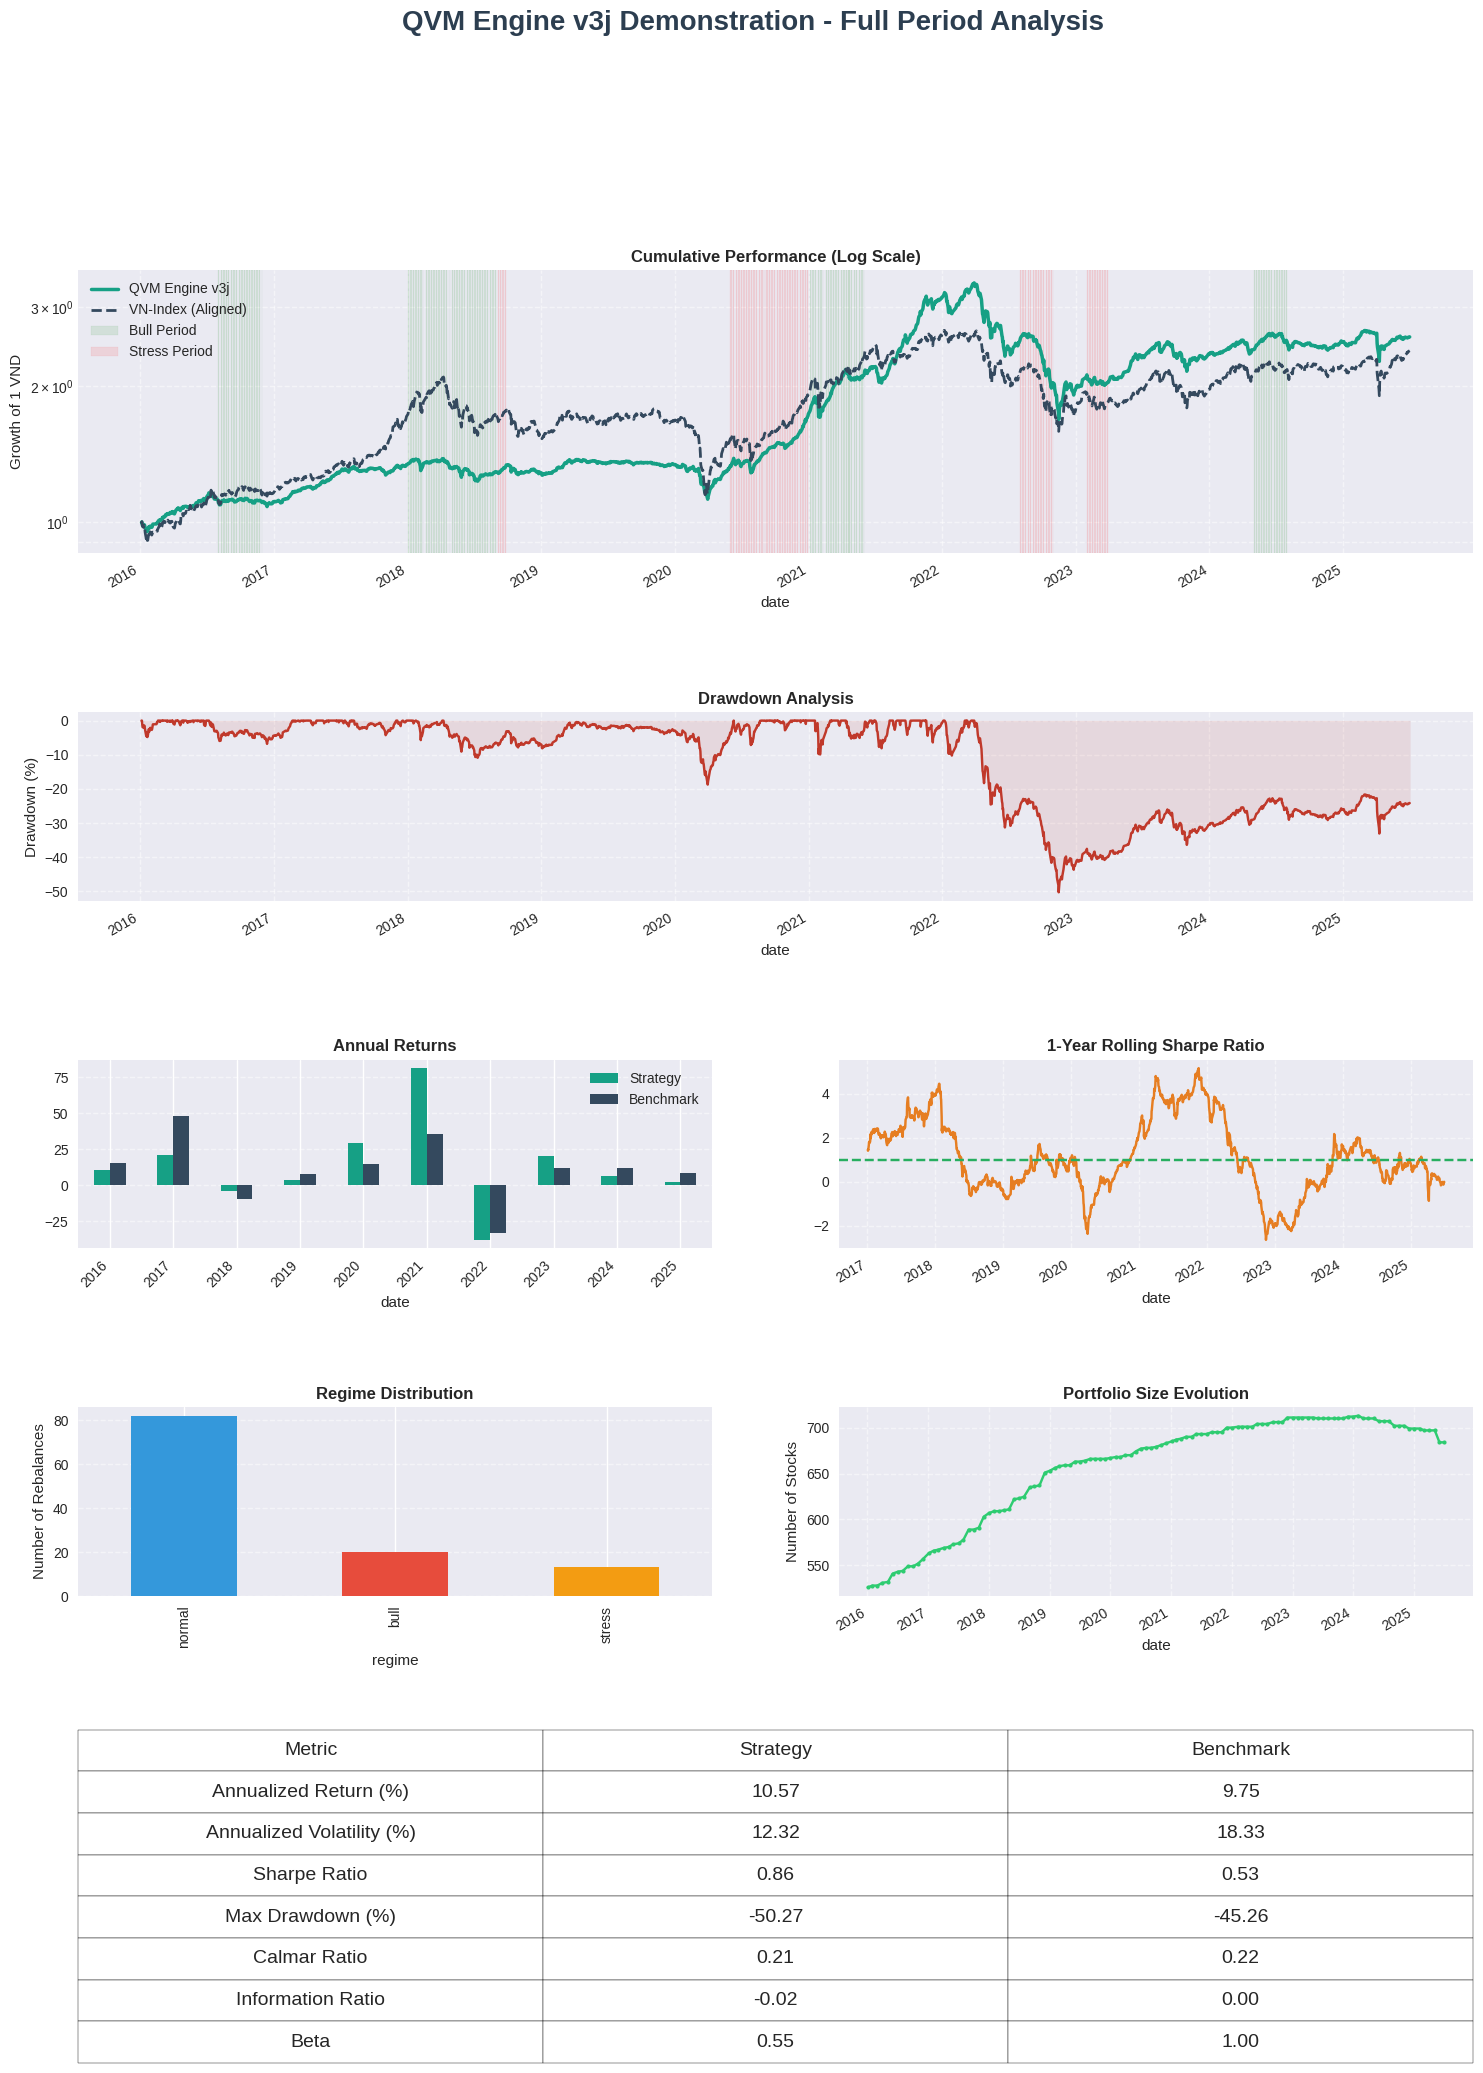

In [19]:
# Generate comprehensive tearsheet with new format
print("\n" + "="*80)
print("📊 QVM ENGINE V3J: COMPREHENSIVE TEARSHEET")
print("="*80)

# Convert daily returns to strategy returns series
strategy_returns = daily_returns.set_index('date')['portfolio_return']
benchmark_returns = benchmark_data.set_index('date')['close_price'].pct_change()

# Create diagnostics DataFrame with regime information
diagnostics = portfolio_values[['date', 'regime', 'regime_allocation', 'valid_holdings']].copy()
diagnostics['portfolio_size'] = diagnostics['valid_holdings']
diagnostics = diagnostics.set_index('date')

# Generate the comprehensive tearsheet
generate_comprehensive_tearsheet(
    strategy_returns,
    benchmark_returns,
    diagnostics,
    "QVM Engine v3j Demonstration - Full Period Analysis"
)

# ADDITIONAL PERIOD TEARSHEETS


📊 QVM ENGINE V3J: FIRST PERIOD TEARSHEET (2016-2020)


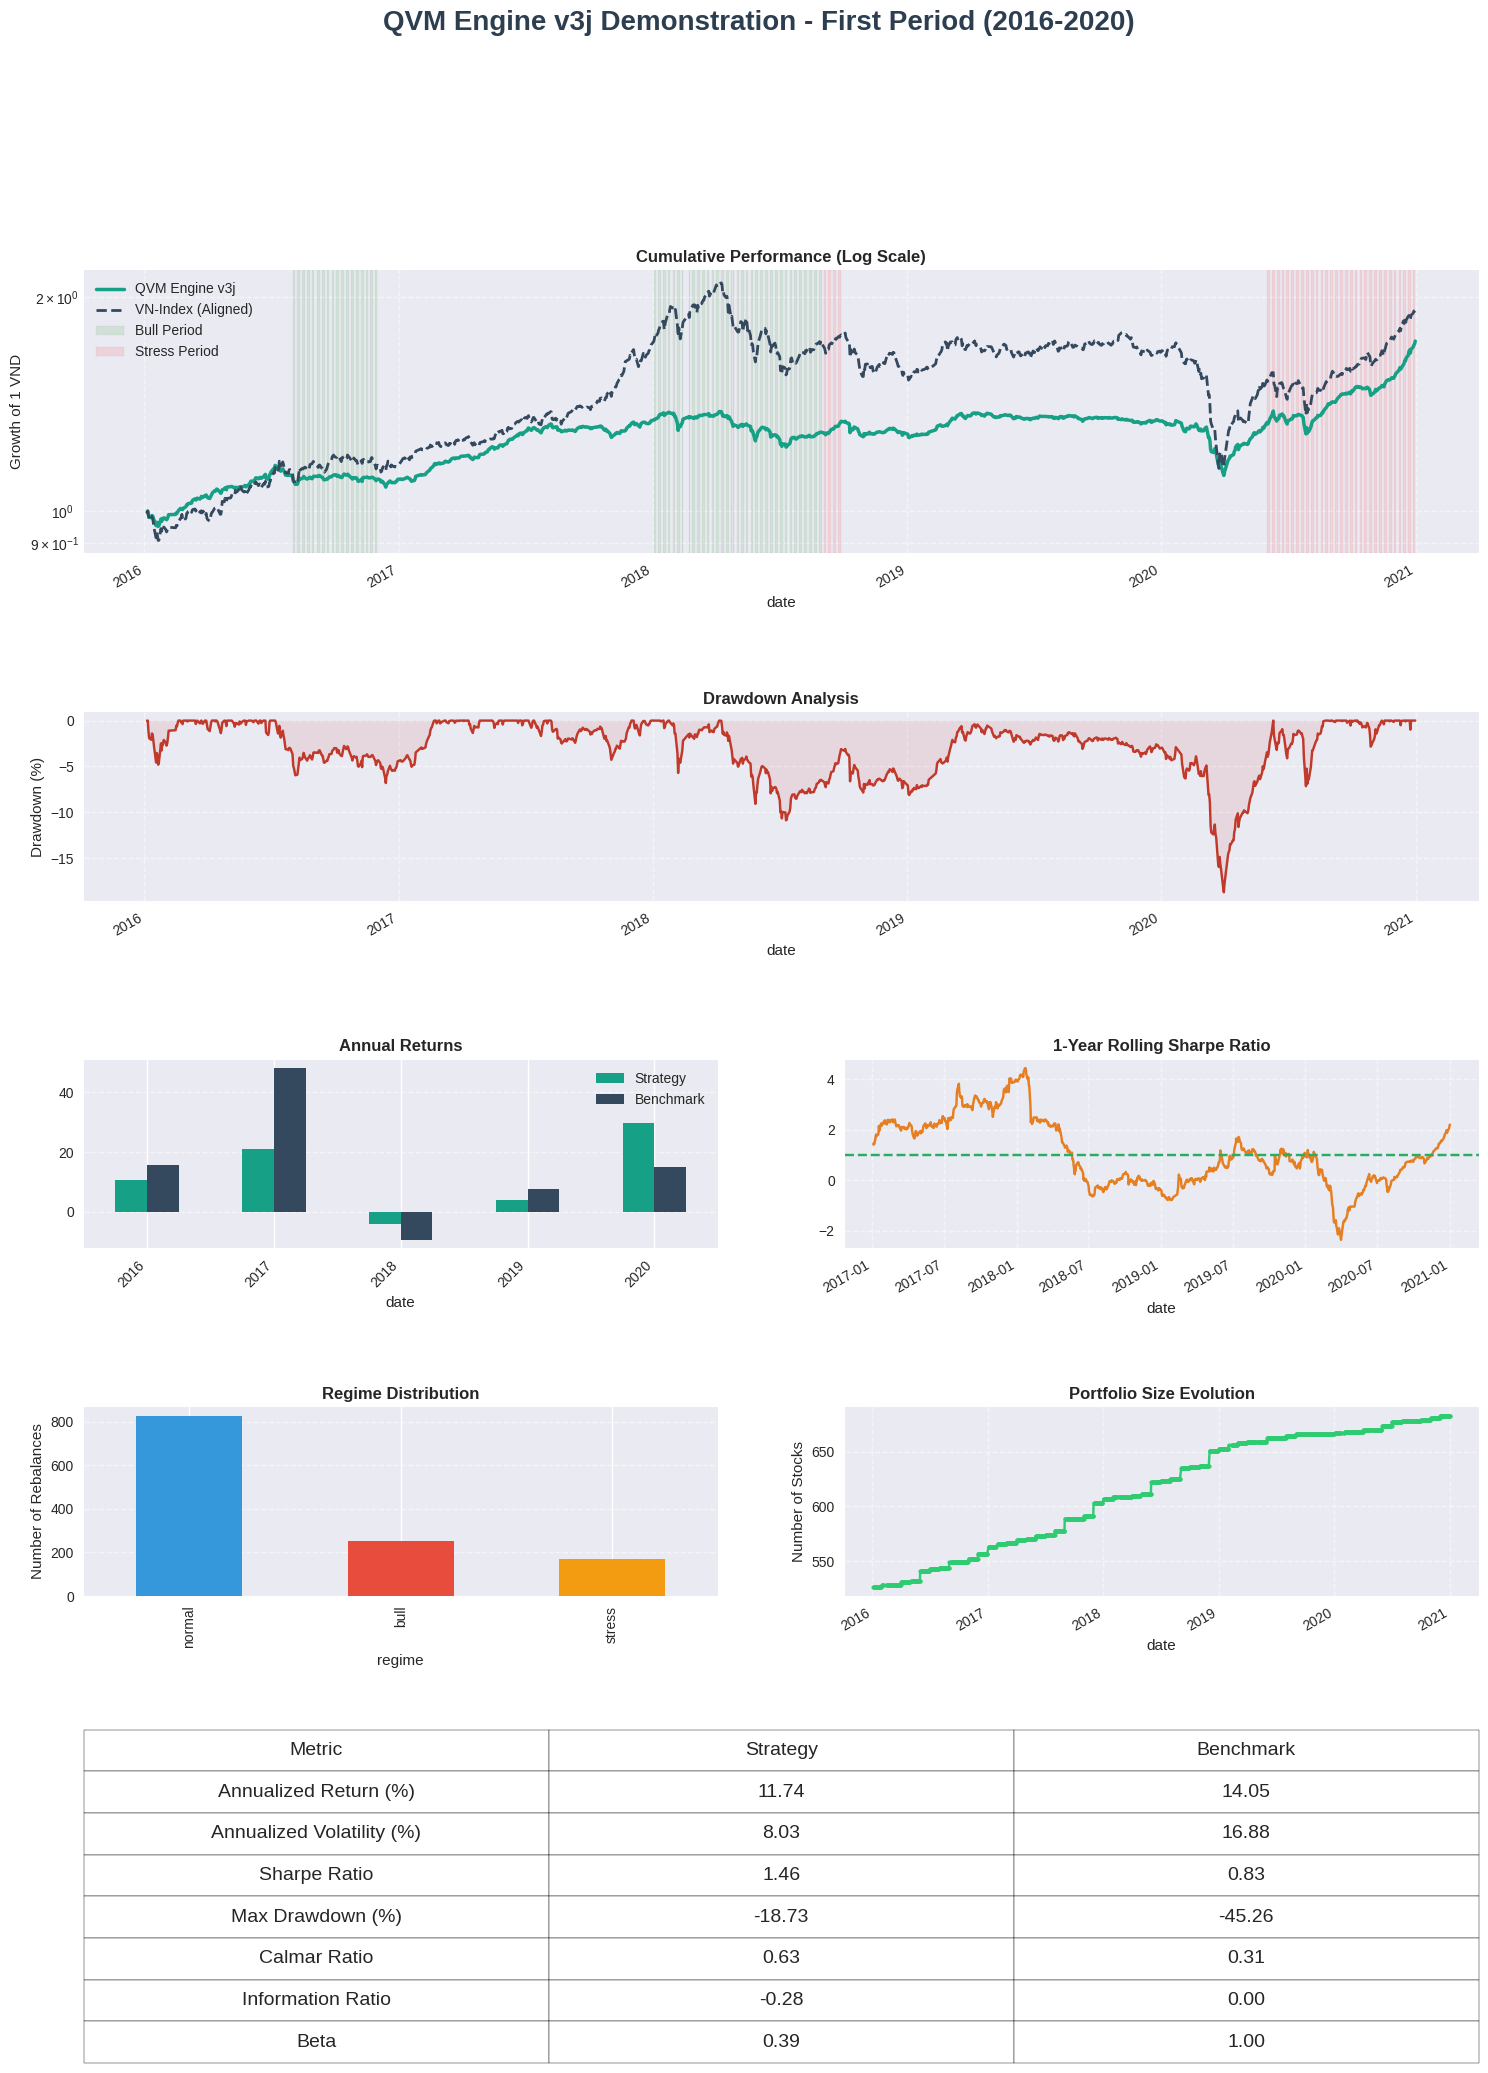


📊 QVM ENGINE V3J: SECOND PERIOD TEARSHEET (2020-2025)


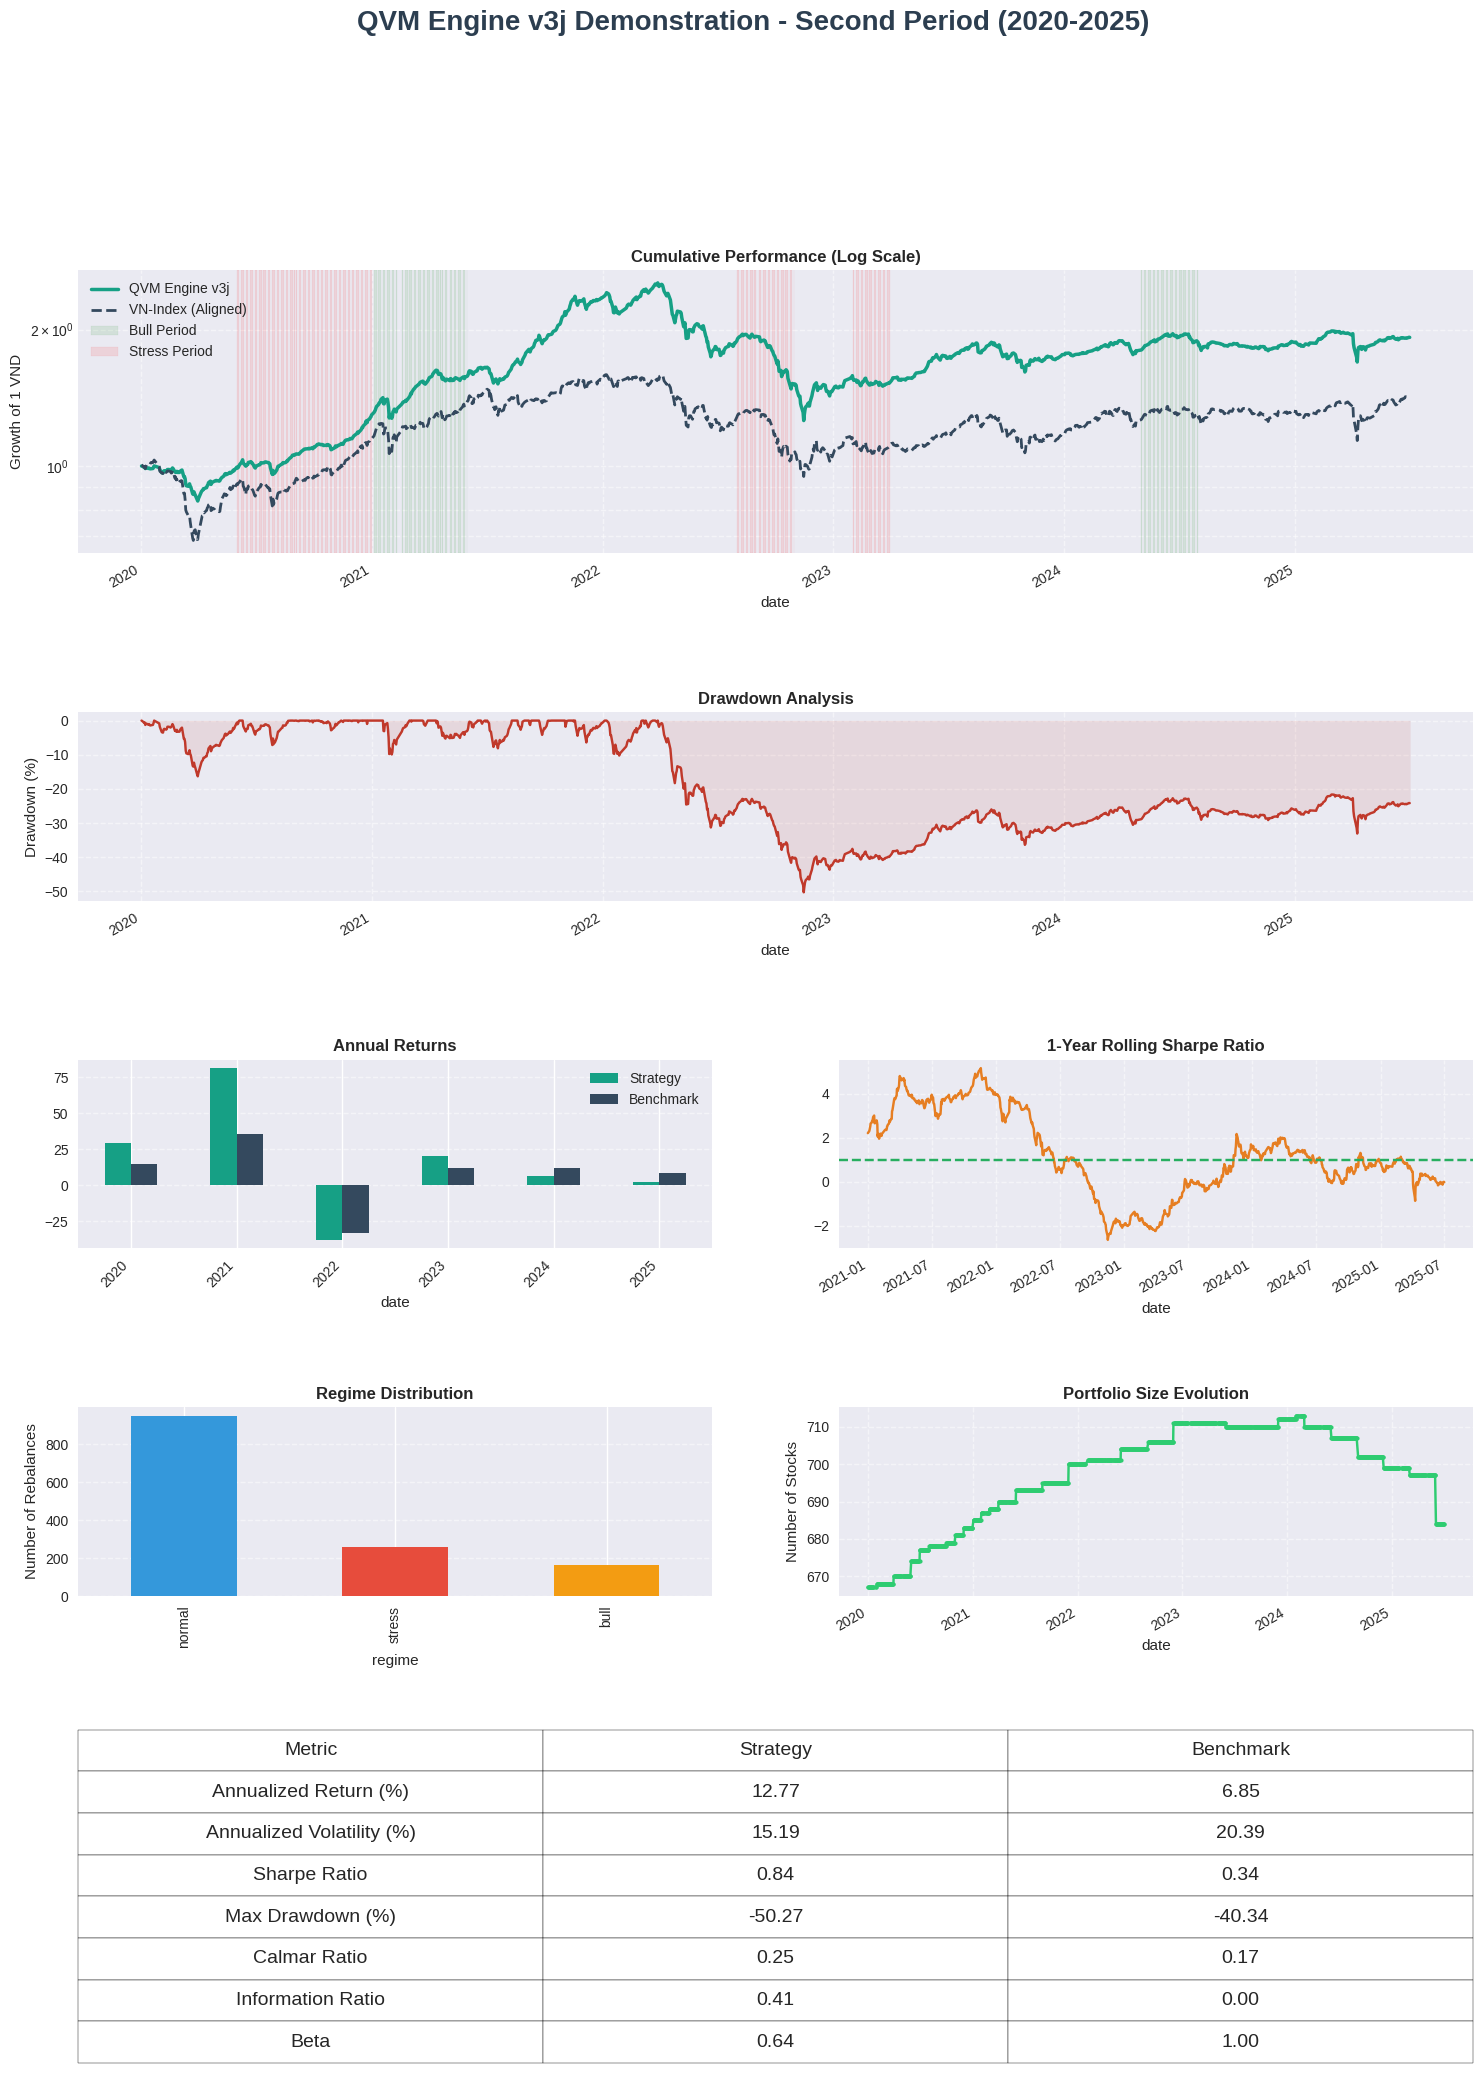

In [20]:
# 1. First Period Tearsheet (2016-2020)
print("\n" + "="*80)
print("📊 QVM ENGINE V3J: FIRST PERIOD TEARSHEET (2016-2020)")
print("="*80)

# Filter data for 2016-2020 period
first_period_mask = (strategy_returns.index >= '2016-01-01') & (strategy_returns.index <= '2020-12-31')
first_period_strategy_returns = strategy_returns[first_period_mask]
first_period_benchmark_returns = benchmark_returns.reindex(first_period_strategy_returns.index).fillna(0)
first_period_diagnostics = diagnostics.reindex(first_period_strategy_returns.index, method='ffill')

# Generate first period tearsheet
generate_comprehensive_tearsheet(
    first_period_strategy_returns,
    first_period_benchmark_returns,
    first_period_diagnostics,
    "QVM Engine v3j Demonstration - First Period (2016-2020)"
)

# 2. Second Period Tearsheet (2020-2025)
print("\n" + "="*80)
print("📊 QVM ENGINE V3J: SECOND PERIOD TEARSHEET (2020-2025)")
print("="*80)

# Filter data for 2020-2025 period
second_period_mask = (strategy_returns.index >= '2020-01-01') & (strategy_returns.index <= '2025-12-31')
second_period_strategy_returns = strategy_returns[second_period_mask]
second_period_benchmark_returns = benchmark_returns.reindex(second_period_strategy_returns.index).fillna(0)
second_period_diagnostics = diagnostics.reindex(second_period_strategy_returns.index, method='ffill')

# Generate second period tearsheet
generate_comprehensive_tearsheet(
    second_period_strategy_returns,
    second_period_benchmark_returns,
    second_period_diagnostics,
    "QVM Engine v3j Demonstration - Second Period (2020-2025)"
)

# SUMMARY

In [21]:
print("\n" + "="*80)
print("🎯 QVM STRATEGY PERFORMANCE SUMMARY")
print("="*80)
print(f"📈 Total Return: {performance_metrics['total_return']:.2%}")
print(f"📊 Annualized Return: {performance_metrics['annualized_return']:.2%}")
print(f"⚡ Sharpe Ratio: {performance_metrics['sharpe_ratio']:.3f}")
print(f"📉 Max Drawdown: {performance_metrics['max_drawdown']:.2%}")
print(f"🎯 Alpha: {performance_metrics['alpha']:.2%}")
print(f"📊 Beta: {performance_metrics['beta']:.3f}")
print(f"🏆 Win Rate: {performance_metrics['win_rate']:.2%}")
print("="*80)


🎯 QVM STRATEGY PERFORMANCE SUMMARY
📈 Total Return: 158.30%
📊 Annualized Return: 10.52%
⚡ Sharpe Ratio: 0.854
📉 Max Drawdown: -50.27%
🎯 Alpha: 5.13%
📊 Beta: 0.553
🏆 Win Rate: 60.24%
